In [1]:
import re   
import os   
import pandas as pd     
import numpy as np    
import tensorflow as tf 
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split  

In [86]:
# 데이터 로드할 때 빠르게 로드
AUTOTUNE = tf.data.experimental.AUTOTUNE

ROOT_PATH =  os.path.join(os.getenv('HOME'), 'aiffel')

BATCH_SIZE = 16

IMAGE_SIZE = [180, 180]

EPOCHS = 25

In [87]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [88]:
# trian : val = 80: 20 으로 분할
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [89]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print('정상 이미지 개수: {0} \n폐렴 이미지 개수: {1}'.format(COUNT_NORMAL, COUNT_PNEUMONIA))

정상 이미지 개수: 1062 
폐렴 이미지 개수: 3123


폐렴 이미지의 수가 정상보다 3배 더 많이 있습니다. 불균형은 나중에 조절하겠습니다.

In [90]:
# 배치처리 작업을 효율적으로 처리하기 위함
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [91]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('train 이미지 개수: {0} \nval 이미지 개수: {1}'.format(TRAIN_IMG_COUNT, VAL_IMG_COUNT))

train 이미지 개수: 4185 
val 이미지 개수: 1047


In [92]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])

In [93]:
# 라벨을 리턴하는 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   

# 이미지 형식을 재지정 해주는 함수
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

# 파일의 이미지와 라벨을 리턴하는 함수
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [94]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [95]:
# 이미지와 라벨이 잘 처리 되었는 지 확인
for image, label in train_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True


In [96]:
# 테스트셋도 똑같이 처리
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [97]:
# data augmentation 함수
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    image = tf.image.random_flip_up_down(image)
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [98]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NOMAL')
        plt.axis('off')

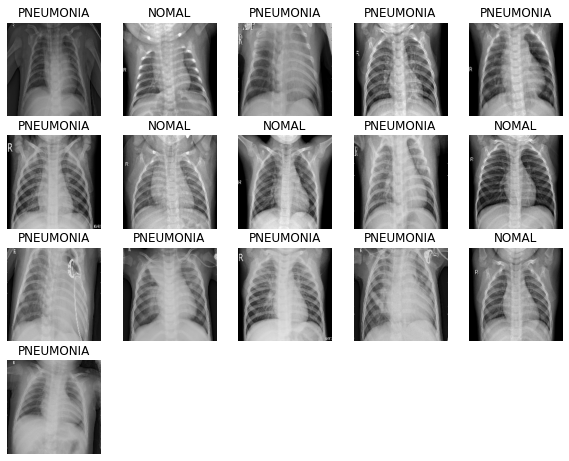

In [99]:
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링

In [100]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

In [101]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [102]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [103]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [104]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 24s 91ms/step - loss: 0.4067 - accuracy: 0.7929 - precision: 0.9577 - recall: 0.7556 - val_loss: 0.6558 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 91ms/step - loss: 0.2269 - accuracy: 0.9107 - precision: 0.9748 - recall: 0.9038 - val_loss: 1.2430 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 92ms/step - loss: 0.2118 - accuracy: 0.9203 - precision: 0.9754 - recall: 0.9163 - val_loss: 0.3966 - val_accuracy: 0.8087 - val_precision: 0.7912 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1821 - accuracy: 0.9322 - precision: 0.9797 - recall: 0.9284 - val_loss: 0.0812 - val_accuracy: 0.9692 - val_precision: 0.9839 - val_recall: 0.9735
Epoch 5/25
261/261 [==============================] - 25s 95ms/step - loss: 0.1652 - accuracy: 0

## Summary

### Augmention 적용 (flip 좌우, 상하)

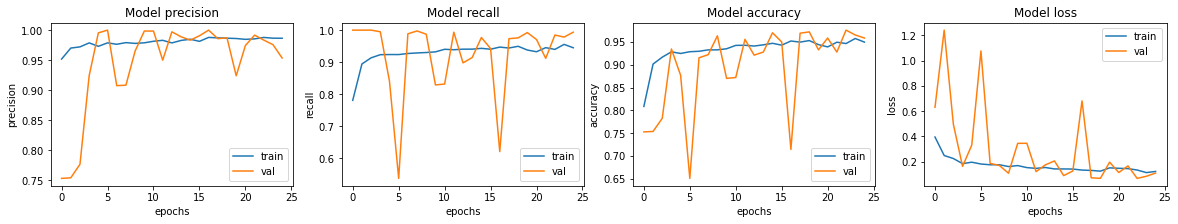

In [80]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [81]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 1.1345 - accuracy: 0.7035 - precision: 0.6783 - recall: 1.0000


In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, acc, prec, rec = model.evaluate(test_ds)